In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import ee
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras import optimizers

In [4]:
#Authenticate and Initialize the google api
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AbUR2VPDBcZmfN0d7P5BXyFJ_wPvNrulr3VphCXI8IaVoLTeQ6qYFc812JE

Successfully saved authorization token.


In [58]:
# NDVI
# Define the latitude and longitude of the point
lat = 35.3357
lon = -0.7778

# Create a point geometry
point = ee.Geometry.Point(lon, lat)

# CNN-LSTM
# Define the number of years of data to use for training
train_years = 12

# Define the number of days of data to use for each time step
time_steps = 365

# Define the number of time steps to uses for each training sequence
sequence_length = 30

# Define the number of filters and kernel size for the CNN layer
num_filters = 64
kernel_size = 3

# Define the number of LSTM units for the LSTM layer
num_lstm_units = 64

# Define the number of epochs and batch size for training
num_epochs = 30
batch_size = 32

# Define the time range for the data
start_date = ee.Date('2004-01-01')
end_date = ee.Date('2020-12-31')

# Retrieve temperature data from Earth Engine
ndvi_collection = ee.ImageCollection('MODIS/MOD09GA_006_NDVI') \
    .select('NDVI')\
    .filterDate(start_date, end_date)
    
# Reduce the image collection to a single image at the given location and time
ndvi_image = ndvi_collection.filterBounds(point)

# Extract the temperature value at the given region
ndvi_data = ndvi_image.getRegion(point, scale=0.01).getInfo()

# Convert the data into a dataframe
ndvi_df = pd.DataFrame({'NDVI': ndvi_data})

#Convert the data into a dataframe
columns = ['id', 'longitude', 'latitude','time','NDVI']
ndvi_df = pd.DataFrame(ndvi_data[1:], columns=columns)
ndvi_df.set_index('id', inplace = True)


#Convert temperature column to float and replace missing values with NaN
ndvi_df['NDVI'] = pd.to_numeric(ndvi_df['NDVI'], errors='coerce')#*0.0001)

# Convert the index to a datetime object
ndvi_df.index = pd.to_datetime(ndvi_df.index, format='%Y_%m_%d')

# Resample the data to daily frequency
ndvi_df_daily = ndvi_df.resample('D').sum()


# Check for missing or nan values
print(ndvi_df_daily['NDVI'].isnull().sum()) # number of missing values
print(np.isinf(ndvi_df_daily['NDVI']).sum()) # number of infinite values


0
0


In [59]:
ndvi_df_daily

,longitude,latitude,time,NDVI
id,,,,
2004-01-01,-0.7778,35.3357,1072915200000,0.058726
2004-01-02,-0.7778,35.3357,1073001600000,-0.006686
2004-01-03,-0.7778,35.3357,1073088000000,1.000000
2004-01-04,-0.7778,35.3357,1073174400000,0.265635
2004-01-05,-0.7778,35.3357,1073260800000,0.195817
...,...,...,...,...
2020-12-26,-0.7778,35.3357,1608940800000,0.203228
2020-12-27,-0.7778,35.3357,1609027200000,0.195230
2020-12-28,-0.7778,35.3357,1609113600000,-0.006850


In [60]:
ndvi_df_daily['NDVI']

id
2004-01-01    0.058726
2004-01-02   -0.006686
2004-01-03    1.000000
2004-01-04    0.265635
2004-01-05    0.195817
                ...   
2020-12-26    0.203228
2020-12-27    0.195230
2020-12-28   -0.006850
2020-12-29    0.004872
2020-12-30    0.283747
Freq: D, Name: NDVI, Length: 6209, dtype: float64

<Axes: xlabel='id'>

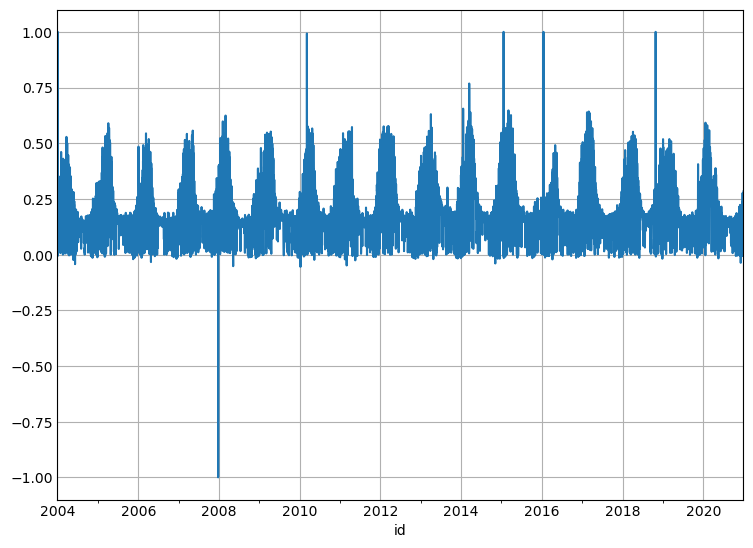

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
ndvi_df_daily['NDVI'].plot()

In [43]:
target_ndvi=np.array(ndvi_df_daily['NDVI'])
target_ndvi_array=target_ndvi.reshape(target_ndvi.shape[0],1,1)

In [44]:
#print(target_ndvi)
print(target_ndvi_array)

[[[ 0.05872639]]

 [[-0.00668588]]

 [[ 1.        ]]

 ...

 [[-0.00685025]]

 [[ 0.00487175]]

 [[ 0.28374654]]]


In [45]:
# Define the input and output features
X = []
Y = []


# Iterate over each sequence in the dataset
for i in range(len(target_ndvi_array) - sequence_length - 1):
    # Extract a sequence of temperature values
    seq_temp = target_ndvi_array[i:i+sequence_length]
    # Define the target temperature value
    target_temp = target_ndvi_array[i+sequence_length]
    
    # Append the sequence and target values to the input and output lists
    X.append(seq_temp)
    Y.append(target_temp)
    
# Convert the input and output lists to numpy arrays
X = np.array(X)
Y = np.array(Y)

In [46]:
#Split the data into train and vali dataset
X_train,X_valid,Y_train,Y_valid=train_test_split(X,Y,test_size=0.4, random_state=0)

print('Train set shape', X_train.shape)
print('Test set shape', X_valid.shape)

Train set shape (3706, 30, 1, 1)
Test set shape (2472, 30, 1, 1)


In [47]:
subsequences=2
timesteps = X_train.shape[1]//subsequences
X_train_sub=X_train.reshape((X_train.shape[0], subsequences, timesteps,1))
X_valid_sub=X_valid.reshape((X_valid.shape[0], subsequences, timesteps,1))

print('Train set shape', X_train_sub.shape)
print('Test set shape', X_valid_sub.shape)

Train set shape (3706, 2, 15, 1)
Test set shape (2472, 2, 15, 1)


In [48]:
epochs = 35
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [49]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_sub.shape[2], X_train_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu')))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

print(model_cnn_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, None, 15, 64)     128       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, None, 15, 64)     4160      
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, None, 15, 64)     4160      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, None, 15, 64)     4160      
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, None, 7, 64)     

In [68]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_sub, Y_train, validation_data=(X_valid_sub, Y_valid), epochs=40, verbose=1)

Epoch 1/40
116/116 [==============================] - 21s 182ms/step - loss: 0.0054 - val_loss: 0.0188
Epoch 2/40
116/116 [==============================] - 21s 183ms/step - loss: 0.0052 - val_loss: 0.0196
Epoch 3/40
116/116 [==============================] - 23s 197ms/step - loss: 0.0052 - val_loss: 0.0187
Epoch 4/40
116/116 [==============================] - 25s 214ms/step - loss: 0.0051 - val_loss: 0.0188
Epoch 5/40
116/116 [==============================] - 26s 223ms/step - loss: 0.0050 - val_loss: 0.0195
Epoch 6/40
116/116 [==============================] - 36s 303ms/step - loss: 0.0047 - val_loss: 0.0201
Epoch 7/40
116/116 [==============================] - 22s 192ms/step - loss: 0.0047 - val_loss: 0.0204
Epoch 8/40
116/116 [==============================] - 24s 209ms/step - loss: 0.0047 - val_loss: 0.0190
Epoch 9/40
116/116 [==============================] - 24s 210ms/step - loss: 0.0046 - val_loss: 0.0204
Epoch 10/40
116/116 [==============================] - 28s 245ms/step - l

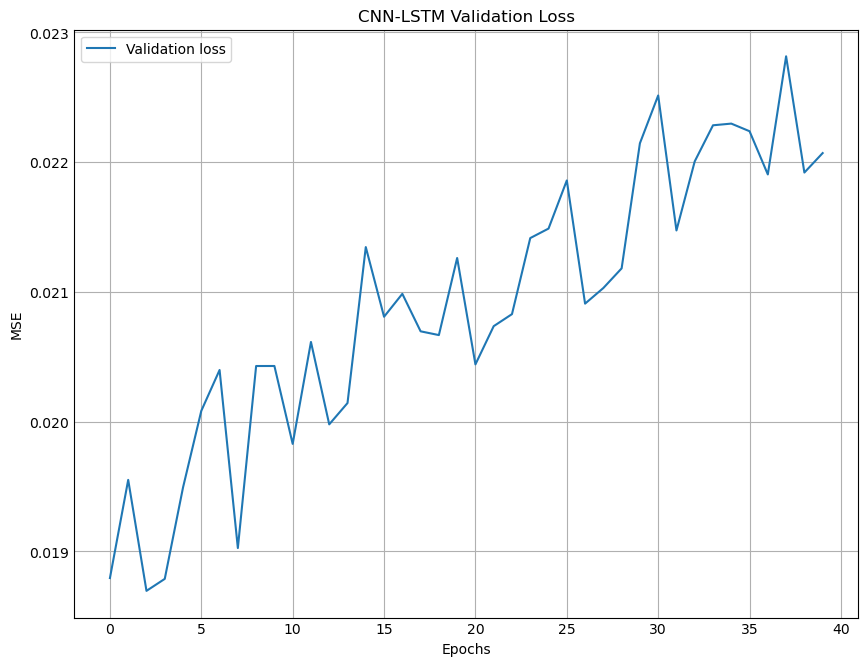

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax.legend(loc='best')
ax.set_title('CNN-LSTM Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('MSE')

plt.show()



In [70]:
#Squeeze the double array
y_train=np.squeeze(Y_train)
y_valid=np.squeeze(Y_valid)

In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_sub)
print('Train rmse:', np.sqrt(mean_squared_error(y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_valid, cnn_lstm_valid_pred)))

78/78 [==============================] - 1s 12ms/step
Train rmse: 0.04457142949849995
Validation rmse: 0.14855977923447508


In [72]:
print(cnn_lstm_valid_pred)

[[0.10516036]
 [0.27183202]
 [0.23465303]
 ...
 [0.10425201]
 [0.38124642]
 [0.3239695 ]]


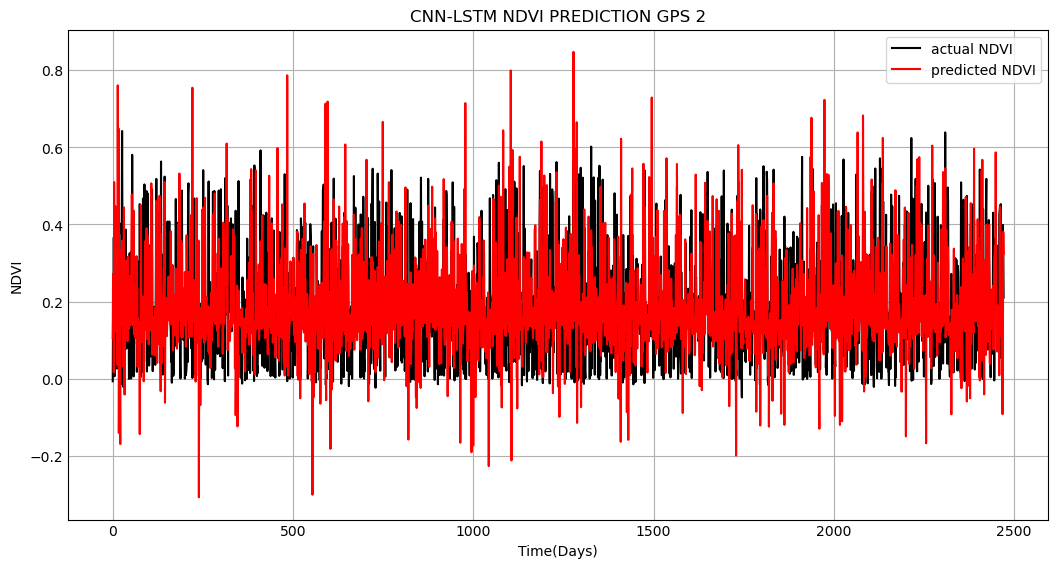

In [73]:
#Plot the comparison between actual temperature and predicted temperature
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.style.use('_mpl-gallery')
plt.plot(y_valid , color='black', label='actual NDVI')
plt.plot(cnn_lstm_valid_pred, color='red', label='predicted NDVI')
plt.title('CNN-LSTM NDVI PREDICTION GPS 2')
plt.xlabel('Time(Days)')
plt.ylabel('NDVI')
plt.legend()
plt.show()